# Demo: Annotating Downsampled Kanemaru2023 Dataset with Pretrained EpiAgent-NT

This notebook demonstrates the process of annotating a downsampled Kanemaru2023 dataset using the pretrained EpiAgent-NT model. 
The following resources are required:
- EpiAgent-NT model (`EpiAgent-NT.pth`)
- Cell type file for EpiAgent-NT (`EpiAgent-NT_cell_types.json`)
- Downsampled Kanemaru2023 dataset (`Kanemaru2023_downsampled_10000_cells.h5ad`)

Please ensure these files are downloaded from: https://drive.google.com/drive/folders/1WlNykSCNtZGsUp2oG0dw3cDdVKYDR-iX?usp=sharing


# Step 1: Data Preprocessing - TFIDF and Tokenization

In this step, we preprocess the input dataset by applying TFIDF to transform discrete count data into continuous values. 
The importance of each accessible cCRE in each cell is quantified. Subsequently, tokenization is performed to generate 
cell sentences, stored in `adata.obs`.

In [1]:
import scanpy as sc
import numpy as np
from epiagent.tokenization import tokenization
from epiagent.preprocessing import global_TFIDF

# Load the AnnData object
input_path = '../data/sample/raw_h5ad/Kanemaru2023_downsampled_10000_cells.h5ad'
adata = sc.read_h5ad(input_path)

# Load the cCRE document frequency and compute TF-IDF
cCRE_document_frequency = np.load('../data/cCRE_document_frequency.npy')
adata = global_TFIDF(adata, cCRE_document_frequency)

# Tokenize the data using the tokenization function
tokenization(adata)

print("Data preprocessing completed: TFIDF applied, and cell sentences generated.")

Tokenization complete: 'cell_sentences' column added to adata.obs.
Data preprocessing completed: TFIDF applied, and cell sentences generated.


# Step 2: Create Dataset and DataLoader for EpiAgent-NT

Here, we construct a PyTorch dataset and dataloader from the processed AnnData object. Each dataset element 
represents a cell sentence, with special tokens ([CLS] and [SEP]) appended. Accessible cCREs are sampled if their 
indices exceed the maximum length.

In [2]:
from epiagent.dataset import CellDataset, collate_fn
from torch.utils.data import DataLoader

# Create dataset
cell_sentences = adata.obs['cell_sentences'].tolist()
dataset = CellDataset(cell_sentences=cell_sentences, max_length=8192)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)

print("Dataset and DataLoader successfully created.")

Dataset and DataLoader successfully created.


# Step 3: Load Pretrained EpiAgent-NT Model

In this step, we load the pretrained EpiAgent-NT model and its associated cell types.

In [3]:
import torch
import json
from sklearn.preprocessing import LabelEncoder
from epiagent.model import EpiAgent_supervised

# Load cell types for EpiAgent-NT
cell_type_file = '../model/EpiAgent-NT/EpiAgent-NT_cell_types.json'
with open(cell_type_file, 'r') as f:
    cell_types_for_epiant_nt = json.load(f)

label_encoder = LabelEncoder()
label_encoder.fit(cell_types_for_epiant_nt)

# Load pretrained model
model_path = '../model/EpiAgent-NT/EpiAgent-NT.pth'
epiagent_nt = EpiAgent_supervised(
    vocab_size=1355449, num_layers=18, embedding_dim=512, num_attention_heads=8, 
    max_rank_embeddings=8192, num_classes=len(cell_types_for_epiant_nt), use_flash_attn=True
)
epiagent_nt.load_state_dict(torch.load(model_path))

print("Pretrained EpiAgent-NT model loaded successfully.")

Pretrained EpiAgent-NT model loaded successfully.


# Step 4: Inference with EpiAgent-NT

Perform inference using the pretrained EpiAgent-NT model to obtain predicted cell types and cell embeddings. 
This step also filters out rare predicted cell types.

In [5]:
from epiagent.inference import infer_cell_types, filter_rare_cell_types

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epiagent_nt.to(device)

# Perform inference
results = infer_cell_types(model=epiagent_nt, device=device, dataloader=dataloader, need_cell_embeddings=True)

# Filter rare predicted cell types
predicted_labels_filtered = filter_rare_cell_types(
    results['predicted_labeles'], np.array(results['predicted_probabilities']), threshold=0.005
)

# Map predicted labels to real cell types
predicted_cell_types = label_encoder.inverse_transform(predicted_labels_filtered)

print("Inference completed: Predicted cell types and embeddings generated.")

Inference completed: Predicted cell types and embeddings generated.


# Step 5: Validation and Visualization

Validate the predictions by visualizing the predicted cell types and comparing them with true cell types using UMAP. 
Additionally, generate a confusion matrix to quantify the performance of the model.

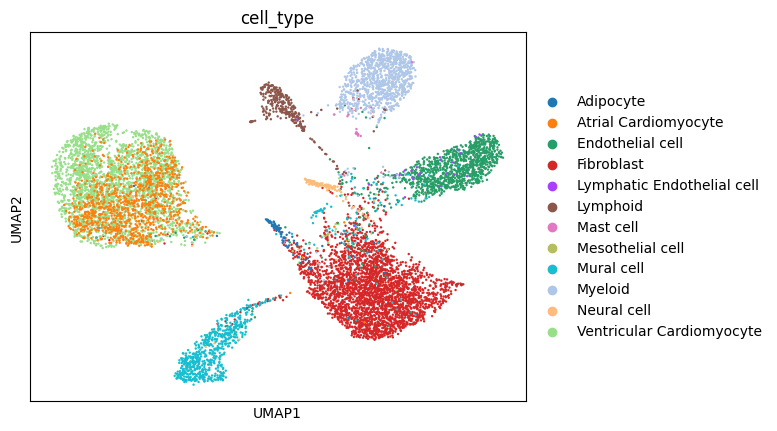

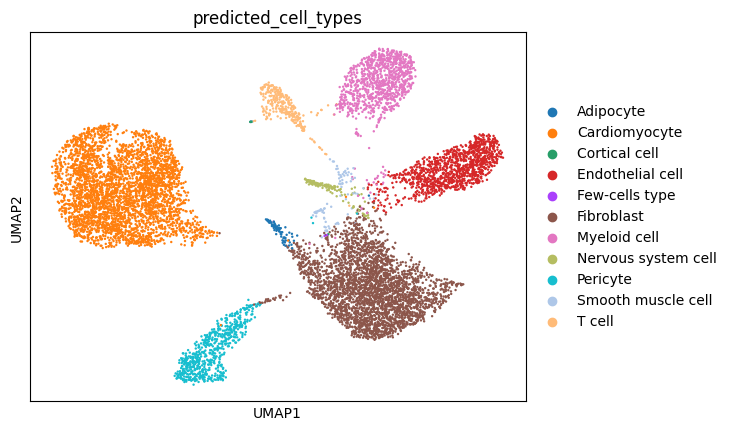

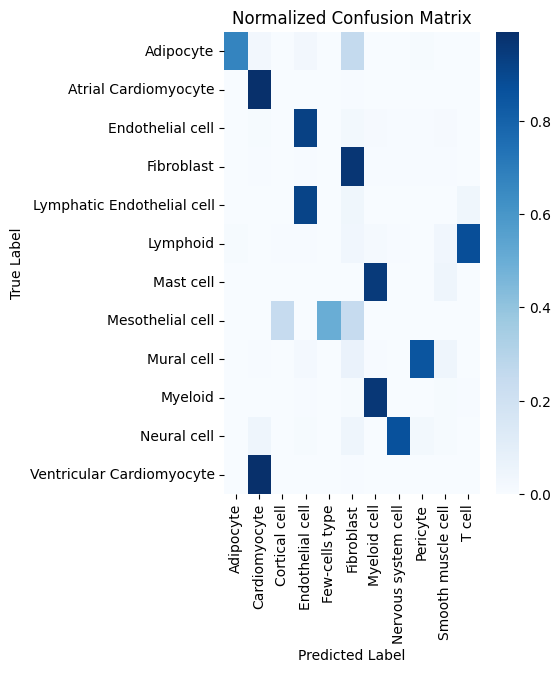

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assign predictions to AnnData
adata.obs['predicted_cell_types'] = predicted_cell_types
adata.obsm['cell_embeddings_from_EpiAgent-NT'] = results['cell_embeddings']

# UMAP visualization
sc.pp.neighbors(adata, use_rep='cell_embeddings_from_EpiAgent-NT')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cell_type'])
sc.pl.umap(adata, color=['predicted_cell_types'])

# Prepare labels for confusion matrix visualization
true_labels = adata.obs['cell_type']
predicted_labels = adata.obs['predicted_cell_types']
true_class_list = sorted(true_labels.unique())
pred_class_list = sorted(predicted_labels.unique())

# Create an empty confusion matrix
conf_matrix = np.zeros((len(true_class_list), len(pred_class_list)), dtype=int)

# Map class names to indices
true_class_to_index = {cls: idx for idx, cls in enumerate(true_class_list)}
pred_class_to_index = {cls: idx for idx, cls in enumerate(pred_class_list)}

# Populate the confusion matrix
for pred, true in zip(predicted_labels, true_labels):
    pred_idx = pred_class_to_index[pred]
    true_idx = true_class_to_index[true]
    conf_matrix[true_idx, pred_idx] += 1

# Convert to DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix, index=true_class_list, columns=pred_class_list)

# Normalize the confusion matrix
normalized_conf_matrix = conf_matrix_df.div(conf_matrix_df.sum(axis=1), axis=0)

# Visualize the confusion matrix
plt.figure(figsize=(0.375 * len(pred_class_list), 0.5 * len(true_class_list)))
sns.heatmap(normalized_conf_matrix, annot=False, fmt=".2f", xticklabels=pred_class_list, yticklabels=true_class_list, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

# Save processed AnnData
output_path = '../data/sample/processed_h5ad/Kanemaru2023_downsampled_10000_cells_EpiAgent-NT_outputs.h5ad'
adata.write(output_path)
print(f"Processed AnnData saved at {output_path}")